### Install and import the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
# Installing cmdstanpy
t = time.time()
!pip install cmdstanpy
print('Time elapsed: {} seconds'.format(time.time() - t))

Time elapsed: 1.0267319679260254 seconds


In [3]:
# If cmdstan is not installed yet:
from cmdstanpy import install_cmdstan
install_cmdstan(verbose=True)

Installing CmdStan version: 2.32.2
Install directory: /Users/haoting/.cmdstan
CmdStan version 2.32.2 already installed


True

In [4]:
# If there is bug while running it on Apple Silicon, try the following:
from cmdstanpy import rebuild_cmdstan
rebuild_cmdstan()

 (00:00) |            | Building CmdStan                     

### Input your data of interest

In [5]:
# For example:
X = np.array([0., 0.01, 0.03, 0.1, 0.3, 1.])
Y = np.array([100., 96.1, 91.6, 78.2, 62.3, 40.8])
print('dosage: ', X, 'response: ', Y)

dosage:  [0.   0.01 0.03 0.1  0.3  1.  ] response:  [100.   96.1  91.6  78.2  62.3  40.8]


In [ ]:
# Alternatively, upload dataset in the form of a .csv file, where the first 
# column is named "dosage", and the second column is named "response".
df = pd.read_csv("your_dose_response_data.csv")
X = df["dosage"]
Y = df["response"]

### Define the model according to Box 1 in the paper

#### Notes:
 - The prior for $E_0$ is defined to be Gaussian with mean $100$ and a standard deviation of $3$ (i.e. $B=100$ where $B$ is defined in the paper). But this may need to be changed according to the range of the responses in the dataset. For example, if the response range is between $0$ and $1$, then the prior for $E_0$ below shall be changed from `e0 ~ normal(100, 3)` to `e0 ~ normal(1, 0.03)`. To do this, define `e0_mean = 1` in the cell below.
 - The Beta prior for the normalised $\text{E}_{\text{inf}}$ is defined according to Option 2 in the paper. To opt for Option 1, define `einf_beta_a = 1` and `einf_beta_b = 1` in the cell below so that we have `einf ~ beta(1, 1)` which is equivalent to `einf ~ uniform(0, 1)`.
 - The bounds for the prior of $\log C$ are defined according to the dosage range of the AstraZeneca-Sanger DREAM challenge. Please refer to the paper for information on how to adjust the bounds (`ic50_lb` and `ic50_ub` in the cell below) if necessary.
 - The prior for $\sigma$ (the standard deviation of the i.i.d. noise) is defined to be lognormal(0, 1), where $\mu=0$ controls the median of the prior. It can be tuned depending on the range of $Y$ and the noise level expected by the user. For example, when the range of $Y$ is between $0$ and $100$, then a lognormal(0, 1) gives a median of 1. But when the range of $Y$ is between $0$ and $1$, then a smaller $\mu$ (e.g. somewhere between -5 and -4) may be more suitable. This could be determined by empirically estimating the noise level from an external dataset. To tune this, change the value of `sigma_mu` in the cell below.

In [6]:
# Define the parameters for the prior distributions
e0_mean = 100
einf_beta_a = 0.46
einf_beta_b = 0.58
ic50_lb = 1e-10
ic50_ub = 1e6
sigma_mu = 0

#### Note: The following cell only needs to be run if you are working on Google Colab. If you are working locally, the following cell does not need to be run, as long as synba_mono.stan is already in the working directory.

In [ ]:
synba_mono = """data {
  int<lower=0> N;
  int<lower=0> N_test;
  vector[N] X;
  vector[N] Y;
  vector[N_test] X_test;
  real<lower=0> e0_mean;
  real<lower=0> einf_beta_a;
  real<lower=0> einf_beta_b;
  real log_ic50_lb;
  real log_ic50_ub;
  real sigma_mu;
}
parameters {
  real<lower=0> e0;
  real<lower=0, upper=1> einf;
  real<lower=log_ic50_lb, upper=log_ic50_ub> logC;
  real<lower=0> h;
  real<lower=0> sigma;
}
model {
    h ~ lognormal(0, 1);
    einf ~ beta(einf_beta_a, einf_beta_b);
    sigma ~ lognormal(sigma_mu, 1);
    e0 ~ normal(e0_mean, 0.03*e0_mean);
    for(i in 1:N)
    Y[i] ~ normal(e0 + (einf * e0 - e0) / (1.0 + (exp(logC) / X[i]) ^ h), sigma);
}
generated quantities {
    vector[N_test] Y_synthetic;
    for(i in 1:N_test){
        Y_synthetic[i] = normal_rng(e0 + (einf * e0 - e0) / (1.0 + (exp(logC) / X_test[i]) ^ h), sigma);
    }
}"""

# THE PATH FOR GOOGLE COLAB:
file_path = '/content/synba_mono.stan'

with open(file_path, 'w') as file:
    file.write(synba_mono)

# Print the file path
print("File saved:", file_path)

### Compile and train the model

In [7]:
# Compile the model
from cmdstanpy import CmdStanModel

t = time.time()
model = CmdStanModel(stan_file='synba_mono.stan')
print('Time taken to compile the model: {} seconds'.format(time.time() - t))

Time taken to compile the model: 0.13647794723510742 seconds


In [12]:
# Fit the model and generate samples
t = time.time()
N = len(Y)
# Add a tiny value to the zeros.
zero_ind = np.where(X == 0)[0]
X[zero_ind] = np.minimum(1e-8, 0.001 * np.min(X[np.where(X>0)[0]]))
data = {'N': N, 'X': X, 'Y': Y, 'N_test': N, 'X_test': X,
          'e0_mean': e0_mean, 'einf_beta_a': einf_beta_a, 'einf_beta_b': einf_beta_b,
          'log_ic50_lb': np.log(ic50_lb), 'log_ic50_ub': np.log(ic50_ub), 'sigma_mu': sigma_mu}
fit = model.sample(data=data)
print('Time taken to compile the model: {} seconds'.format(time.time() - t))

17:09:43 - cmdstanpy - INFO - CmdStan start processing
17:09:43 - cmdstanpy - INFO - CmdStan done processing.
17:09:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_mono.stan', line 27, column 4 to column 81)
Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_mono.stan', line 27, column 4 to column 81)
Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_mono.stan', line 27, column 4 to column 81)
Exception: normal_lpdf: Location parameter is nan, but must be finite! (in '/Users/haoting/Documents/GitHub/SynBa/synba_mono.stan', line 27, column 4 to column 81)
Consider re-running with show_console=True if the above output is unclear!
17:09:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 5 dive

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
Time taken to compile the model: 0.4871952533721924 seconds


### Output Analysis

#### Summary statistics
Note: The "einf" in the summary table is normalised, so its range is (0, 1) instead of (0, e0).

In [13]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,0.383295,0.141433,2.485070,-4.410210,0.825934,3.527930,308.731,467.066,1.01946
e0,100.268000,0.031125,0.958620,98.788200,100.261000,101.781000,948.560,1435.040,1.01314
einf,0.084037,0.006576,0.069780,0.000493,0.072772,0.213423,112.584,170.324,1.03664
logC,-0.776930,0.018629,0.217296,-1.179130,-0.742537,-0.502893,136.054,205.830,1.03037
h,0.795031,0.006370,0.065772,0.708922,0.783351,0.913564,106.619,161.300,1.03745
sigma,1.078260,0.020038,0.505225,0.560632,0.940741,2.052380,635.740,961.785,1.00828
Y_synthetic[1],100.260000,0.036745,1.523540,97.913600,100.245000,102.658000,1719.100,2600.760,1.00939
Y_synthetic[2],95.986200,0.026417,1.364160,93.806100,96.002200,98.095000,2666.570,4034.140,1.00102
Y_synthetic[3],90.745700,0.029438,1.384130,88.541700,90.749200,92.913800,2210.690,3344.460,1.00407
Y_synthetic[4],79.106600,0.023482,1.412460,76.858700,79.091600,81.342700,3618.210,5473.840,1.00086


#### Output visualisation
Note: Tune the A and B for different sizes of the histograms for Emax and IC50.

Red histogram: The posterior distribution for IC50.
Green histogram: The posterior distribution for Emax.
Light blue curves: Sample dose-response curves from the posterior.
Red bell curves: The estimated noise level for the responses.


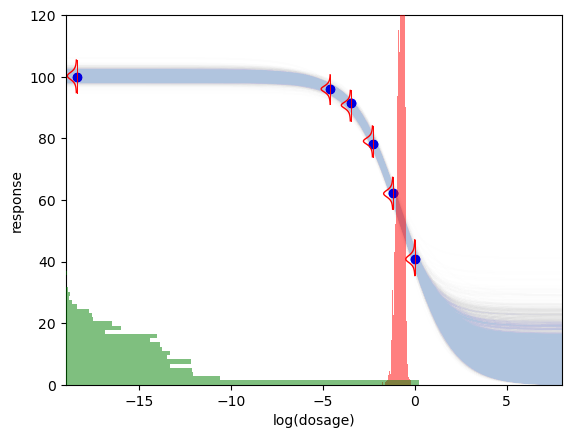

In [14]:
# Extracting traces
e0, einf, logC, h, sigma = fit.stan_variable('e0'), fit.stan_variable('einf'), fit.stan_variable('logC'), \
                           fit.stan_variable('h'), fit.stan_variable('sigma')

A, B = 1.5, 0.2
print("Red histogram: The posterior distribution for IC50.")
print("Green histogram: The posterior distribution for Emax.")
print("Light blue curves: Sample dose-response curves from the posterior.")
print("Red bell curves: The estimated noise level for the responses.")

# Plotting regression line
log_x_min, log_x_max = int(np.floor(np.log(np.min(X)))), int(np.ceil(np.log(np.max(X)))) + 8
log_x_plot = np.linspace(log_x_min, log_x_max, 100)
yy_max = np.repeat(-e0_mean, len(Y))
yy_min = np.repeat(e0_mean, len(Y))

fig, ax1 = plt.subplots()
# Plot the sampled regression lines
for i in range(len(e0)):
    yy = e0[i] + (einf[i] * e0[i] - e0[i]) / (1.0 + (np.exp(logC[i]) / np.exp(log_x_plot)) ** h[i])
    ax1.plot(log_x_plot, yy, color='lightsteelblue', alpha=0.005)
    yy_x = e0[i] + (einf[i] * e0[i] - e0[i]) / (1.0 + (np.exp(logC[i]) / X) ** h[i])
    yy_max = np.maximum(yy_max, yy_x + sigma[i])
    yy_min = np.minimum(yy_min, yy_x - sigma[i])
for i in range(len(X)):
    support = np.linspace(yy_min[i], yy_max[i], 100)
    p_x = np.zeros(np.shape(support))
    for j in range(len(e0)):
        delta_support = support - (e0[j] + (einf[j] * e0[j] - e0[j]) / (1.0 + (np.exp(logC[j]) / X[i]) ** h[j]))
        gaussian = np.exp((-delta_support ** 2.0) / (2 * sigma[j] ** 2.0))
        gaussian *= -1
        p_x += gaussian
    p_x = p_x / np.max(np.abs(p_x)) * 0.5
    ind = np.where(np.abs(p_x)>0.01)[0]
    ax1.plot(p_x[ind] + np.log(X[i]), support[ind], c='red', linewidth=1)
    ax1.plot(np.zeros_like(p_x[ind]) + np.log(X[i]), support[ind], c='red', linewidth=0.7)

# Plot the original data
ax1.scatter(np.log(X), Y, c='blue')
ax1.set_xlabel('log(dosage)')
ax1.set_ylabel('response')
ax1.set_xlim(log_x_min, log_x_max)
ax1.set_ylim(0, 1.2 * np.max(Y))

# Plot data
ax1.scatter(np.log(X), Y, c='blue')

# Plot IC50 (with direct histogram)
ax2 = ax1.twinx()
ax2.axis('off')
ax2.hist(logC, 30, density=True, color='r', alpha=0.5)
ax2.set_ylim(0, A)

# Plot Emax (with direct histogram)
einf_rescaled = einf * e0
ax3x = ax1.twinx()
ax3 = ax3x.twiny()
ax3.hist(einf_rescaled, 30, density=True, color='green', alpha=0.5, orientation="horizontal")
ax3.set_xlim(0, B)
ax3.set_ylim(0, 1.2 * np.max(Y))
ax3x.axis('off')
ax3.axis('off')

plt.show()